In [5]:
import pandas as pd
df = pd.read_csv("./utils/RAC.csv", sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1607 entries, 0 to 1606
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          1607 non-null   int64  
 1   Month         1607 non-null   int64  
 2   AGE_BEN_SNDS  1607 non-null   int64  
 3   BEN_SEX_COD   1607 non-null   int64  
 4   RAC           1607 non-null   float64
 5   FLT_PAI_MNT   1607 non-null   float64
dtypes: float64(2), int64(4)
memory usage: 75.5 KB


In [6]:
import pandas as pd

df_1 = pd.read_csv("./utils/Population_2024.csv", sep=',')
df_melted = pd.melt(
    df_1,
    id_vars=['Tranche_age'],
    value_vars=['Hommes', 'Femmes'],
    var_name='Sexe',
    value_name='Population'
)
df_melted


,Tranche_age,Sexe,Population
0,0-19,Hommes,8075000
1,20-29,Hommes,3967000
2,30-39,Hommes,4105000
3,40-49,Hommes,4173000
4,50-59,Hommes,4391000
5,60-69,Hommes,3926000
6,70-79,Hommes,3090000
7,80+,Hommes,1554000
8,0-19,Femmes,7660000
9,20-29,Femmes,3885000


In [7]:
tranche_age_mapping = {0:'0-19',
                       20:'20-29',
                       30:'30-39',
                       40:'40-49',
                       50:'50-59',
                       60:'60-69',
                       70:'70-79',
                       80:'80+'}

sexe_mapping = {1:'Hommes',
                2:'Femmes'}

In [8]:
year_of_interest = 2024

df_filtered = df[(df['AGE_BEN_SNDS']!=99) & (df['Year'] == year_of_interest) & (df['BEN_SEX_COD'] != 0)]
                 
df_filtered['AGE_BEN_SNDS'] = df_filtered['AGE_BEN_SNDS'].apply(lambda x: tranche_age_mapping.get(x, x))

df_filtered['BEN_SEX_COD'] = df_filtered['BEN_SEX_COD'].apply(lambda x: sexe_mapping.get(x, x))




/tmp/ipykernel_3040341/1627381187.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['AGE_BEN_SNDS'] = df_filtered['AGE_BEN_SNDS'].apply(lambda x: tranche_age_mapping.get(x, x))
/tmp/ipykernel_3040341/1627381187.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['BEN_SEX_COD'] = df_filtered['BEN_SEX_COD'].apply(lambda x: sexe_mapping.get(x, x))


In [9]:
grouped_df = df_filtered.drop(columns = ['Year', 'Month']).groupby(['AGE_BEN_SNDS', 'BEN_SEX_COD']).sum()

In [10]:
grouped_df.reset_index(inplace=True)

In [11]:
grouped_df.columns = ['Tranche_age', 'Sexe', 'RAC', 'montant_payé']
grouped_df

,Tranche_age,Sexe,RAC,montant_payé
0,0-19,Femmes,3.057116e+09,7.140063e+09
1,0-19,Hommes,2.967448e+09,7.594290e+09
2,20-29,Femmes,1.779467e+09,5.123348e+09
3,20-29,Hommes,1.145011e+09,3.331655e+09
4,30-39,Femmes,2.369822e+09,7.363761e+09
5,30-39,Hommes,1.501460e+09,4.456610e+09
6,40-49,Femmes,2.925823e+09,8.275569e+09
7,40-49,Hommes,2.098525e+09,6.150056e+09
8,50-59,Femmes,3.704022e+09,1.128171e+10
9,50-59,Hommes,3.007810e+09,9.928618e+09


In [12]:
merged_df = pd.merge(df_melted, grouped_df, how='outer', on=['Tranche_age', 'Sexe'])
merged_df['montant_payé_par_personne'] = merged_df['montant_payé'] / merged_df['Population']
merged_df['RAC_par_personne'] = merged_df['RAC'] / merged_df['Population']
meaned_df = merged_df.drop(columns = ['Tranche_age']).groupby(['Sexe']).mean().reset_index()
meaned_df['Tranche_age'] = 'Moyenne'

final_df = pd.concat([merged_df, meaned_df], ignore_index=True)
final_df.to_csv('./Depense et RAC par sexe et par age_2024.csv', sep=',', index=False)

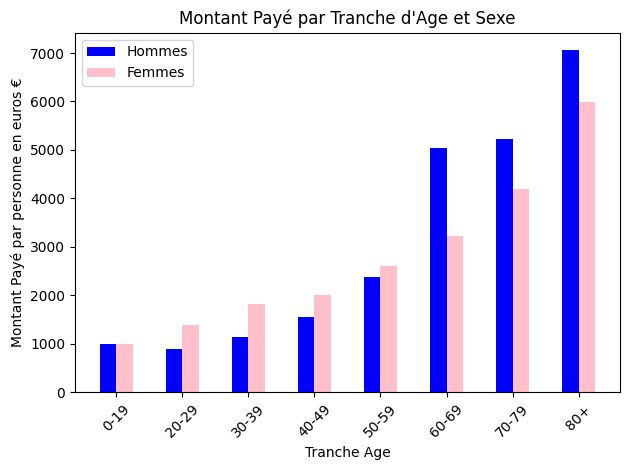

In [32]:
import numpy as np

import matplotlib.pyplot as plt

# Prepare data
x = grouped_df['Tranche_age'].unique()
bar_width = 0.25
index = np.arange(len(x))

# Separate data by Sexe
hommes_data = merged_df[merged_df['Sexe'] == 'Hommes']['montant_payé_par_personne']
femmes_data = merged_df[merged_df['Sexe'] == 'Femmes']['montant_payé_par_personne']

# Plot bars
plt.bar(index, hommes_data, bar_width, label='Hommes', color='blue')
plt.bar(index + bar_width, femmes_data, bar_width, label='Femmes', color='pink')

# Add labels and title
plt.xlabel('Tranche Age')
plt.ylabel('Montant Payé par personne en euros €')
plt.title('Montant Payé par Tranche d\'Age et Sexe')
plt.xticks(index + bar_width / 2, x, rotation=45)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

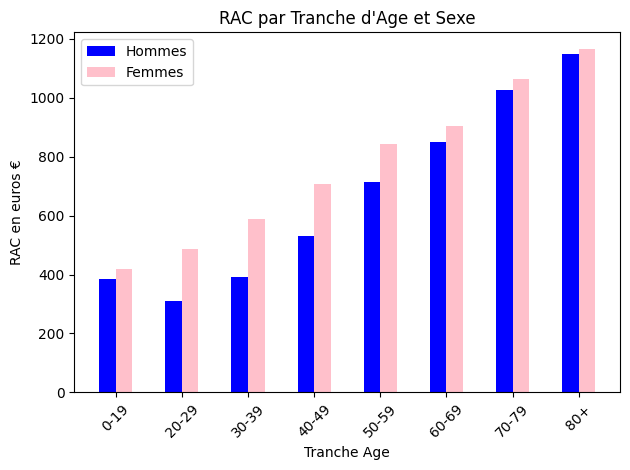

In [11]:
import numpy as np

import matplotlib.pyplot as plt

# Prepare data
x = grouped_df['Tranche_age'].unique()
bar_width = 0.25
index = np.arange(len(x))

# Separate data by Sexe
hommes_data = merged_df[merged_df['Sexe'] == 'Hommes']['RAC_par_personne']
femmes_data = merged_df[merged_df['Sexe'] == 'Femmes']['RAC_par_personne']

# Plot bars
plt.bar(index, hommes_data, bar_width, label='Hommes', color='blue')
plt.bar(index + bar_width, femmes_data, bar_width, label='Femmes', color='pink')

# Add labels and title
plt.xlabel('Tranche Age')
plt.ylabel('RAC en euros €')
plt.title('RAC par Tranche d\'Age et Sexe')
plt.xticks(index + bar_width / 2, x, rotation=45)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()